In [1]:
import random
import numpy as np  
import torch
import matplotlib.pyplot as plt
from functools import partial
from os.path import dirname, join as pjoin
import scipy
import scipy.io as sio

from accuracy_bounds.data.generator_functions import random_uni_points_in_ball
from accuracy_bounds.utils.visualizations import plot_wckersize_conv, plot_avkersize_conv, visualize_ball_3d
from accuracy_bounds.algo.kernel_size import compute_wc_kernel_size, compute_av_kernel_size
from accuracy_bounds.algo.projections import apply_forwardmodel
from accuracy_bounds.data.dataset import GeneratorDataset
from accuracy_bounds.utils.utils import set_seed

### **Example 2:** Worst Case Kernel Size over Flouresence Microscopy Data

In [2]:
# Get the filename for an example .mat file from the  examples/flourescencemicroscopy directory.
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/initial_data_extended/data_S1'
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/initial_data_extended/data_S1'
#data_dir1=  '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/data_S2'
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/data_S3'
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/withoutnonconvergence/data_S1'
data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/withoutnonconvergence/data_S2'

### Construct Feasible Sets for 1 Example of Flouresence Microscopy Data (I=1)

In [3]:
def load_xy_components(mat_contents):
    """ Load xyz components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: xyz component feasible set for measurement of matrix."""

    x = np.array(mat_contents['x_grnd']).flatten()
    xm=np.array(mat_contents['x_mcmc']).flatten()
    x=np.concatenate((x,xm), axis=None)

    y = np.array(mat_contents['y_grnd']).flatten()
    ym=np.array(mat_contents['y_mcmc']).flatten()
    y=np.concatenate((y,ym), axis=None)

    # z is zero currently
    #z = np.array(mat_contents['z_grnd']).flatten()
    #zm=np.array(mat_contents['z_mcmc']).flatten()
    #z=np.concatenate((z,zm), axis=None)

    #create feasible set for one measurement
    f_xy= np.stack((x,y), axis=1)
    return f_xy

In [4]:
def load_ch_components(mat_contents):
    """ Load ch components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: ch component feasible set for measurement of matrix."""

    c = np.array(mat_contents['C_grnd']).flatten()
    cm=np.array(mat_contents['C_mcmc']).flatten()
    c=np.concatenate((c,cm), axis=None)

    h = np.array(mat_contents['h_grnd']).flatten()
    hm=np.array(mat_contents['h_mcmc']).flatten()
    h=np.concatenate((h,hm), axis=None)

    #create feasible set for example 001
    f_ch= np.stack((c,h), axis=1)
    return f_ch

In [5]:
# get list of xy feasible set data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
feasible_sets_list = []
for i in range(1,26):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy feasible set from example i
  f_xy=load_xy_components(mat_contents)
  # add feasible set to list of feasible sets
  feasible_sets_list.append(f_xy)


### **Example 2:** Kernel Sizes for Example Flouresence Microscopy Data

In [6]:
def compute_worstcase_average_kersize_one_feas(feas):
    """" Compute average and worst case kernel size with the l2 norm from one feasible set.
    Args:
        -feas: array of elements in one feasible set
    Returns: 
        - average_kersize_y: average diameter of feas (feasible set)
        - num_feas: number of elements in feas (feasible set)
        - max_diam_Fy: largest diameter of feas (feasible set) or also worst case kernel size
    """
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []
    num_feas = np.array(np.shape(feas))[0].astype(int)
    # compute diameters
    for h in range(0,num_feas,1):
        for j in range(0,h+1,1):
            #compute vectors in null space of F and their norm
            dist_ns = feas[h]-feas[j]
            diameter= np.linalg.norm(dist_ns, ord = 2)

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                            
    # get mean over diams, with factor 2 due to symmetry of the norm of the compute vectors in null space of F (norm(x-z)=norm(z-x))
    # and divided by num_feas^2 ad we have that many terms
    if num_feas > 0:      
        # compute 2 times sum over diams to the power p divided by num_feas^2
        average_kersize_y = 2*np.divide(np.sum(np.power(diam_y,2)), np.power(num_feas,2))
        average_kersize_y = np.power(average_kersize_y, 0.5)
    elif num_feas==0:
        average_kersize_y = 0  

    return average_kersize_y, num_feas, max_diam_Fy
    

### Compute worst case and average kernel size per example

In [7]:
#get 2 times sqrt of average kernel size per sample
average_kersize = []
diameters = []

for i in range(0,25):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    average_kersize.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])[0])
    diameters.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])[2])
    
diameters=np.array(diameters)
diameters= np.multiply(diameters, 1000)
average_kersize=np.array(average_kersize)
kernel_size_nm= np.multiply(average_kersize, 1000)

print(kernel_size_nm)
print(diameters)

[  14.87453693   13.05211968   15.92466207   16.52877579   16.77368654
 1164.19131272   14.63142384   16.6516651    17.3112466    14.97206916
   17.18111329   16.02625365   17.53845882   14.9737023    17.23682357
   12.40655529   16.85611238  203.8826256    15.60969986   16.46718978
   14.19060641   15.44779899   15.11982164   15.59587096   15.03524897]
[  35.89054489   35.58559742   48.08258651   45.27438677   53.29260412
 2731.90629477   35.4099467    49.11512198   42.04715567   45.12667386
   46.41530173   45.65078922   47.47105893   41.32577671   47.76656845
   32.70560223   42.9580566  1243.25456402   42.11163875   42.68207379
   39.26977284   42.74113241   47.44794364   46.49679218   43.30887707]


### Make Table Content with average and worst-case kernel size per example

In [8]:
#def make_latex_table(average_ker,wc_ker):
for i in range(len(diameters)):
    x =  f"example {str(i+1).zfill(3)} &"+str(round(kernel_size_nm[i],4))+"nm &"+str(round(diameters[i],4))+"nm \\"+"\\"
    print(x)


example 001 &14.8745nm &35.8905nm \\
example 002 &13.0521nm &35.5856nm \\
example 003 &15.9247nm &48.0826nm \\
example 004 &16.5288nm &45.2744nm \\
example 005 &16.7737nm &53.2926nm \\
example 006 &1164.1913nm &2731.9063nm \\
example 007 &14.6314nm &35.4099nm \\
example 008 &16.6517nm &49.1151nm \\
example 009 &17.3112nm &42.0472nm \\
example 010 &14.9721nm &45.1267nm \\
example 011 &17.1811nm &46.4153nm \\
example 012 &16.0263nm &45.6508nm \\
example 013 &17.5385nm &47.4711nm \\
example 014 &14.9737nm &41.3258nm \\
example 015 &17.2368nm &47.7666nm \\
example 016 &12.4066nm &32.7056nm \\
example 017 &16.8561nm &42.9581nm \\
example 018 &203.8826nm &1243.2546nm \\
example 019 &15.6097nm &42.1116nm \\
example 020 &16.4672nm &42.6821nm \\
example 021 &14.1906nm &39.2698nm \\
example 022 &15.4478nm &42.7411nm \\
example 023 &15.1198nm &47.4479nm \\
example 024 &15.5959nm &46.4968nm \\
example 025 &15.0352nm &43.3089nm \\


### Compute  worst case and average kernel size over all examples

In [9]:

def av_kernelsize(feasible_sets_list, p=2):
    """
    Computes the average kernel size for a noisy inverse problem under Algorithm 2.

    Args:
        - feasible_sets_list: list of feasible sets with each list entry correpsonding to one measurement.
        - p: order of the norm, default p=2 for MSE computation.

    Returns:
        Approximate average kernel size for for a set of input data samples.
    """

    av_kersizep = 0
    num_samples = len(feasible_sets_list)

    for i in range(0,num_samples):
        # compute diameter of feasible set for one input data point (num_feas will be used for statistics later on)
        average_kersize_y, num_feas, max_diam_Fy = compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])
        #add diameters means for obtaining average kersize to the power p
        av_kersizep = av_kersizep + np.power(average_kersize_y,p)
        
    # get mean over input data
    av_kersize = np.divide(av_kersizep, num_samples)    
    # take power 1/p to obtain average kersize
    av_kersize =  np.power(av_kersize, 1/p)
    
    return av_kersize


In [10]:
print(np.multiply(av_kernelsize(feasible_sets_list, p=2),1000))

236.86251164462703


In [11]:
def wc_kernelsize(feasible_sets_list, p=2):
    """
    Computes the worst-case kernel size for noisy inverse problem using Algorithm 1.

    Args:
        - feasible_sets_list: list of feasible sets
        - p: order of the norm, default p=2 for MSE computation.

    Returns:
        Approximate worst-case kernel size for a set of input data samples.
    """
    wc_kersize =0

    num_samples = len(feasible_sets_list)

    for i in range(0,num_samples):
        # compute diameter of feasible set for one input data point
        diameter_mean_y, num_feas, max_diam_Fy = compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])
        if max_diam_Fy > wc_kersize:
            wc_kersize = max_diam_Fy
    
    return wc_kersize

In [12]:
print(wc_kernelsize(feasible_sets_list, p=2))

2.731906294766419


### Visualize feasible sets

In [13]:
# get three dimensional positions by adding z-component to xy components
new_list_of_arrays = []
k=len(feasible_sets_list)
for i in range(k):
    for j in range(81):
        x=np.multiply(np.array(feasible_sets_list)[i,j],1000)
        new_list_of_arrays.append(np.append(x,0))

# get positions in nm
#np.multiply(new_list_of_arrays, 1000)
print(new_list_of_arrays)


[array([ 1.40938647, 10.77933423,  0.        ]), array([-20.29007255,  20.03761367,   0.        ]), array([-12.79064884,   8.18495045,   0.        ]), array([-14.1532045 ,  12.41196212,   0.        ]), array([-8.08427246, 25.02292171,  0.        ]), array([-17.29814398,  15.87701437,   0.        ]), array([-4.18432774,  8.42986384,  0.        ]), array([-5.39613087, 13.40376127,  0.        ]), array([-6.18213609, 21.4270063 ,  0.        ]), array([-10.9516601 ,  20.19700352,   0.        ]), array([-2.58725374, 15.92564186,  0.        ]), array([-4.75193737, 34.48915156,  0.        ]), array([ 4.09565839, 19.76004898,  0.        ]), array([ 2.37817112, 26.66277071,  0.        ]), array([ 1.09553033, 25.04316852,  0.        ]), array([-3.6769722 , 27.59311134,  0.        ]), array([-4.21339579,  6.29452589,  0.        ]), array([-3.72827517, 14.61677938,  0.        ]), array([-8.50935348, 23.60968152,  0.        ]), array([-8.37373046, 24.14453158,  0.        ]), array([-12.82332846,  21

### Plot feasible sets

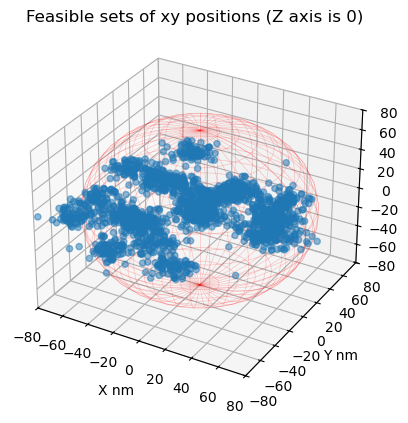

In [14]:
# set radius and center in nm
radius = 80
center = [0,0,0]
# use new 3d data
new_list_of_arrays = np.array(new_list_of_arrays)

# plot feasible sets
visualize_ball_3d(points=new_list_of_arrays, radius=radius, center=center, title="Feasible sets of xy positions (Z axis is 0)", x_axis="X nm", y_axis="Y nm")

### Convergence study: Compute average kernel size per example for different numbers of samples in the feasible sets

In [15]:
# get list of xy feasible set data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
feasible_sets_list = []
for i in range(1,6):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy feasible set from example i
  f_xy=load_xy_components(mat_contents)
  # add feasible set to list of feasible sets
  feasible_sets_list.append(f_xy)

In [16]:
# test convergence over number of points in feasible sets for first example
#get 2 times sqrt of average kernel size per sample
n = len(feasible_sets_list[0])
av_diameters = []

for i in range(0,n, 1):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    av_diameters.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[4][:i])[0])
    
av_diameters=np.array(av_diameters)
kernel_size= np.power(av_diameters, 0.5)
kernel_size_nm= np.multiply(kernel_size, 1000)

print(kernel_size_nm)

[  0.           0.         137.54073911 124.68336949 120.22973002
 125.64894208 125.42320684 131.92416297 131.81036658 129.13267055
 127.98282167 126.65322134 126.32657032 126.83075477 125.61809005
 123.9259894  122.42959598 124.32998075 126.17944102 124.82402258
 123.30928452 122.20160569 121.63987539 120.48950324 119.7830148
 120.5556488  120.43417869 120.39093409 121.00756784 121.63556057
 122.35785413 122.78617053 128.38829104 127.95541638 127.63739878
 127.55790669 127.80381485 127.56754471 128.68892201 129.05785138
 128.54758856 127.93628612 127.20114206 127.44263047 126.7435726
 127.53342279 127.8731326  127.84935124 128.79344684 129.61777357
 130.07014816 129.81641973 129.36059137 128.98013836 128.78521582
 128.73463007 128.85236599 128.51788356 128.10379837 128.14817871
 128.88246646 128.75826926 129.68282603 129.58375486 129.2233891
 128.74123471 128.43475037 129.72428744 129.79424183 130.64215262
 130.61126619 130.49727946 131.01231663 131.02317043 130.63143247
 130.22046923

#### Costum Plot for Convergence over elements in feasible sets

In [19]:
def plot_avkersize_conv(av_kersize, av_kersizes, ker_size, max_k):

    # Plot results
    x_axis = np.arange(1, max_k+1,1)
    y_axis = np.array(av_kersizes)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.3 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples in feasible set")
    plt.ylabel("Average kernel size nm")
    plt.title("Number of Samples vs Average Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

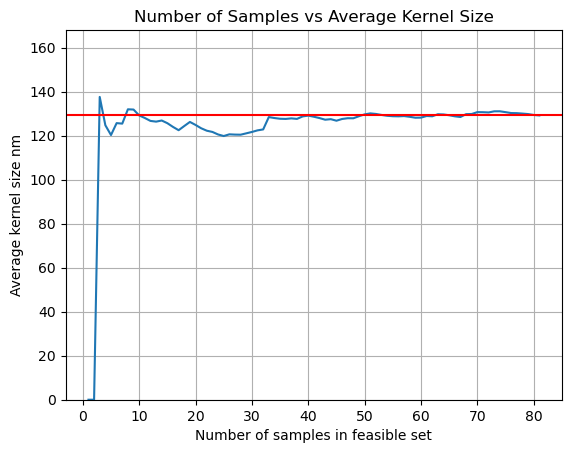

Total Max Kernel Size: 129.1494836177753
Analytical Kernel Size: 129.1494836177753
Relative Error: 0.0


In [21]:
plot_avkersize_conv(kernel_size_nm[-1], kernel_size_nm, kernel_size_nm[-1], 81)

## Hacky stuff to get .dat file for violin plot of kernel sizes

In [ ]:
import pandas as pd

In [ ]:
# average and worst case kernel sizes for each example from S1 and S2 withoutnonconvergence datasets
data = {'S1avks': [2.81984274, 2.52456285, 2.93999364, 2.87908577, 2.48313559, 2.52985472, 2.63549547, 2.86734038, 2.79981648, 2.72337587, 2.69917413, 2.85854827, 2.90281476, 2.53415562, 2.45653896, 2.76292702, 2.9642318,  2.50742732, 2.33954273, 2.85029076, 2.66870454, 2.48782874, 2.33447335, 3.10600412, 2.36194411],
'S1wcks': [7.88910328, 7.24699002, 7.5747996,  9.1317229,  6.67577104, 6.29607315, 6.96026567, 8.71377922, 6.60072404, 7.27140664, 7.4406676,  7.6568002, 8.09088206, 7.2105533,  7.55455232, 7.20595675, 7.88631337, 6.44527337, 7.13049569, 7.0552734,  6.42944878, 7.73534217, 6.45264071, 9.1462696, 6.36679565],
'S2avks': [14.87453693,   13.05211968,   15.92466207,   16.52877579,   16.77368654, 1164.19131272,   14.63142384 ,  16.6516651,    17.3112466 ,   14.97206916, 17.18111329 ,  16.02625365 ,  17.53845882,   14.9737023 ,   17.23682357, 12.40655529,   16.85611238,  203.8826256,    15.60969986,   16.46718978, 14.19060641,   15.44779899,   15.11982164,   15.59587096,   15.03524897],
'S2wcks': [35.89054489,   35.58559742 ,  48.08258651,   45.27438677,   53.29260412, 2731.90629477,   35.4099467,    49.11512198,   42.04715567,   45.12667386, 46.41530173,   45.65078922,   47.47105893,   41.32577671,   47.76656845, 32.70560223,   42.9580566,  1243.25456402,   42.11163875,   42.68207379, 39.26977284 ,  42.74113241,   47.44794364 ,  46.49679218,   43.30887707]}
df = pd.DataFrame(data)

# Transpose the DataFrame using .transpose()
df_transposed = df.transpose()

In [ ]:

print(df)

      S1avks    S1wcks       S2avks       S2wcks
0   2.819843  7.889103    14.874537    35.890545
1   2.524563  7.246990    13.052120    35.585597
2   2.939994  7.574800    15.924662    48.082587
3   2.879086  9.131723    16.528776    45.274387
4   2.483136  6.675771    16.773687    53.292604
5   2.529855  6.296073  1164.191313  2731.906295
6   2.635495  6.960266    14.631424    35.409947
7   2.867340  8.713779    16.651665    49.115122
8   2.799816  6.600724    17.311247    42.047156
9   2.723376  7.271407    14.972069    45.126674
10  2.699174  7.440668    17.181113    46.415302
11  2.858548  7.656800    16.026254    45.650789
12  2.902815  8.090882    17.538459    47.471059
13  2.534156  7.210553    14.973702    41.325777
14  2.456539  7.554552    17.236824    47.766568
15  2.762927  7.205957    12.406555    32.705602
16  2.964232  7.886313    16.856112    42.958057
17  2.507427  6.445273   203.882626  1243.254564
18  2.339543  7.130496    15.609700    42.111639
19  2.850291  7.0552